In [1]:
# RELOADS FOR EASY EDITING.

%load_ext autoreload
%autoreload 2

In [2]:
# GET THE DATAFRAME.

import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [3]:
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [4]:
# PERFORM AN OPTUNA HYPERPARAMETER SEARCH, CAN CHANGE THE SEARCH SPACE IN OPT.PY

from eppi_text_classification import (
    OptunaHyperparameterOptimisation,
)

# YOU MUST SELECT A DB URL WHERE YOUR OPTUNA DB IS.
optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "SVC",
    n_trials_per_job=1,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
)

optimiser.delete_optuna_study(study_name="svc_binary")
best_params = optimiser.optimise_hyperparameters(study_name="svc_binary")

[I 2024-08-07 18:56:52,744] A new study created in RDB with name: svc_binary
[I 2024-08-07 18:57:14,827] Trial 1 finished with value: 0.949653909528477 and parameters: {'C': 9.30325981324357}. Best is trial 1 with value: 0.949653909528477.
[I 2024-08-07 18:57:14,844] Trial 0 finished with value: 0.9507698711052267 and parameters: {'C': 1.0618257460662668}. Best is trial 0 with value: 0.9507698711052267.
[I 2024-08-07 18:57:15,177] Trial 3 finished with value: 0.949653909528477 and parameters: {'C': 3.911331348964039}. Best is trial 0 with value: 0.9507698711052267.
[I 2024-08-07 18:57:15,477] Trial 4 finished with value: 0.949653909528477 and parameters: {'C': 6551.744063676507}. Best is trial 0 with value: 0.9507698711052267.
[I 2024-08-07 18:57:15,516] Trial 2 finished with value: 0.949653909528477 and parameters: {'C': 20.48006760527658}. Best is trial 0 with value: 0.9507698711052267.
[I 2024-08-07 18:57:15,553] Trial 5 finished with value: 0.9503743306977759 and parameters: {'C': 

In [5]:
# FIT THE MODEL

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# model = SVC(**best_params)

model = SVC(
    class_weight="balanced",
    cache_size=1000,
    probability=False,
    C=3000,
    kernel="rbf",
    shrinking=False,
    tol=1e-8,
    gamma="auto",
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=7
)

model.fit(X_train, y_train)

SVC(C=3000, cache_size=1000, class_weight='balanced', gamma='auto',
    shrinking=False, tol=1e-08)

In [6]:
# CREATE ROC CURVE TO SELECT THRESHOLD

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [7]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)

threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [8]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

  0%|          | 0/100 [00:00<?, ?it/s]

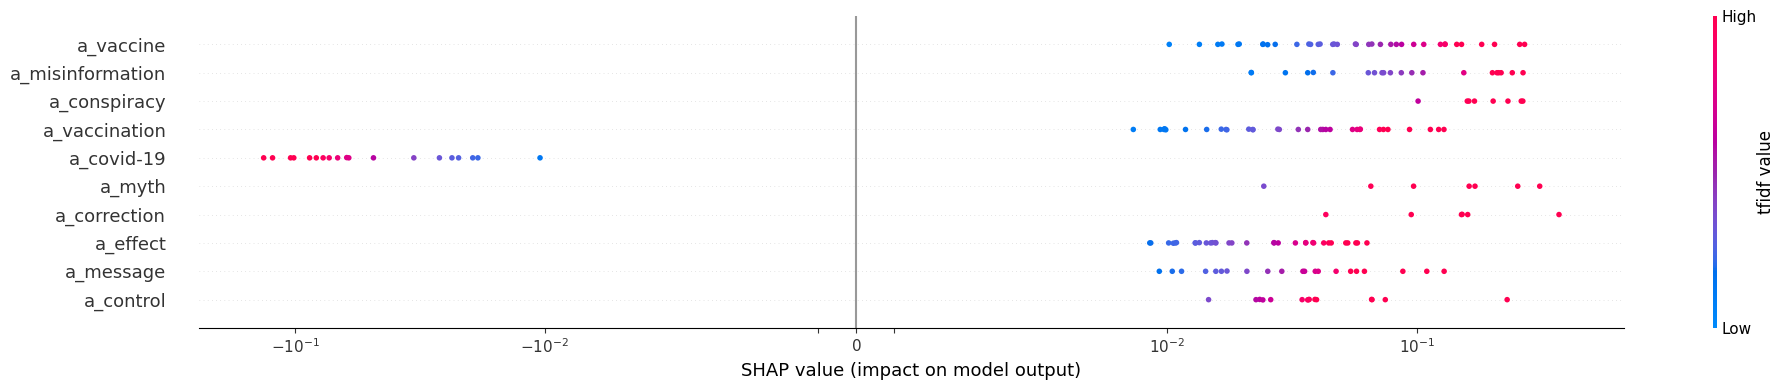

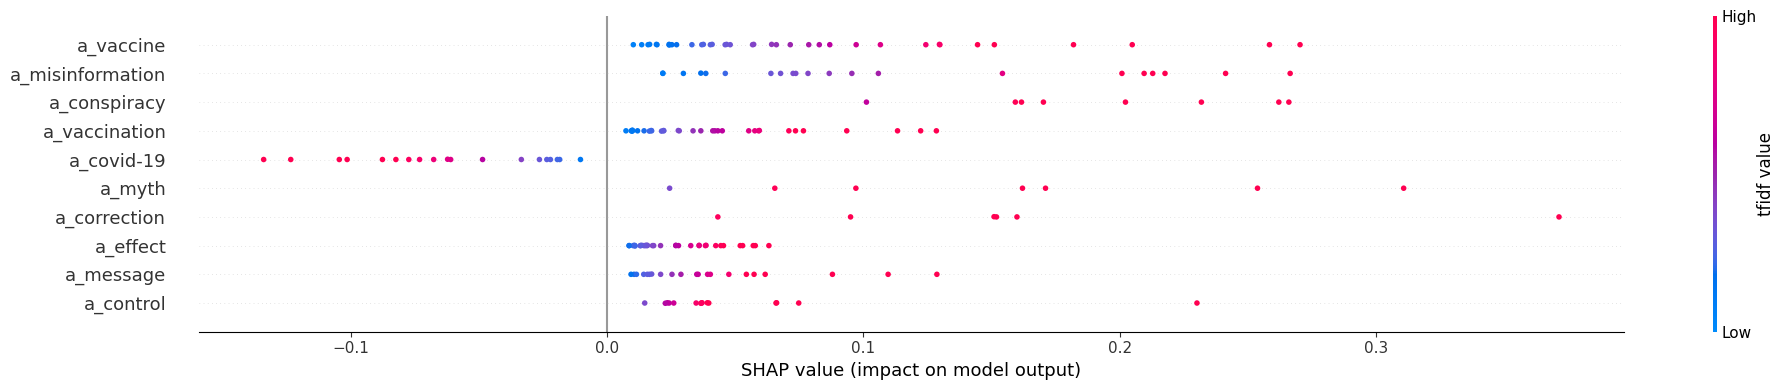

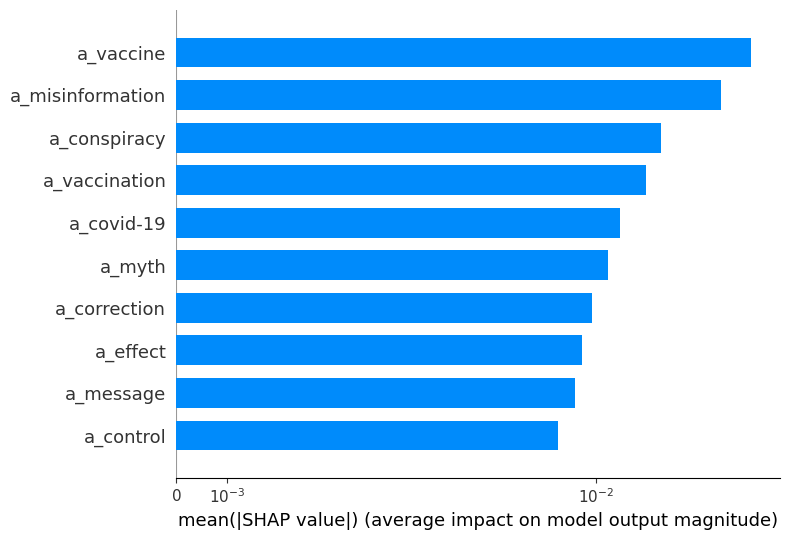

In [9]:
# EXLPAIN THE MODEL

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test[:100], feature_names)

dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=True)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

  0%|          | 0/10 [00:00<?, ?it/s]

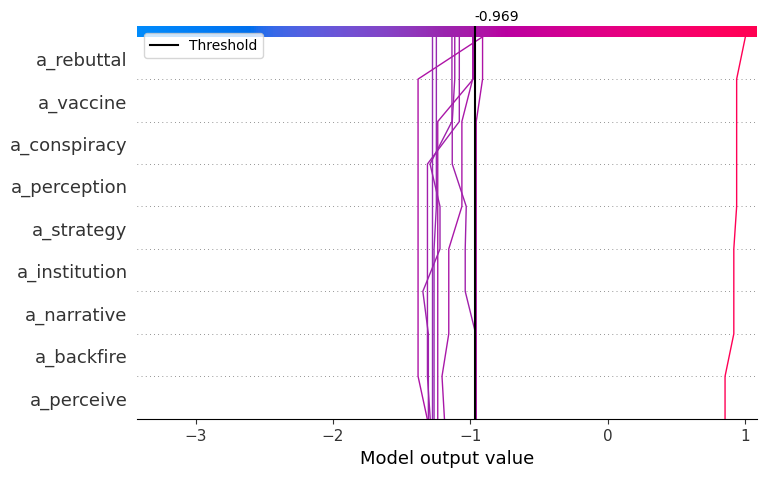

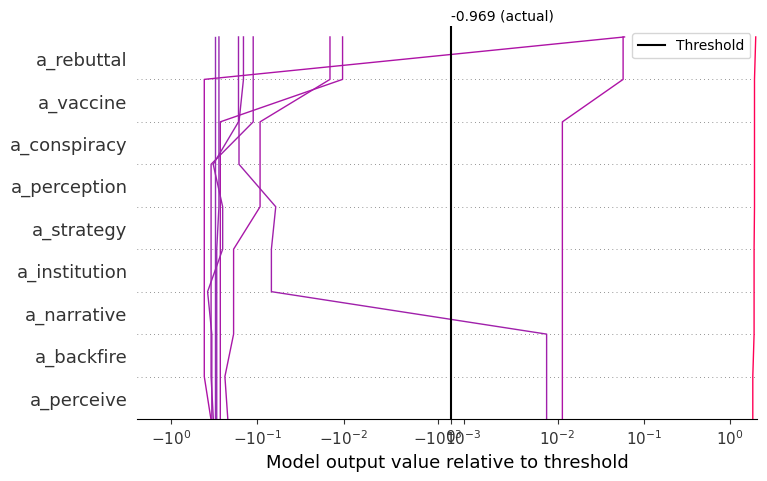

In [10]:
# MAKE THE DECISION PLOTS

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test[:10], feature_names, kernel_nsamples=256)
decision_plot = shap_plotter.decision_plot(threshold=threshold, num_display=10)
decision_plot.show()
decision_plot = shap_plotter.decision_plot(
    threshold=threshold, num_display=10, log_scale=True
)
decision_plot.show()

Truth: 0
Prediction: [0]
Shap value: -1.0812476488855125
Prediction score: [-1.08124765]


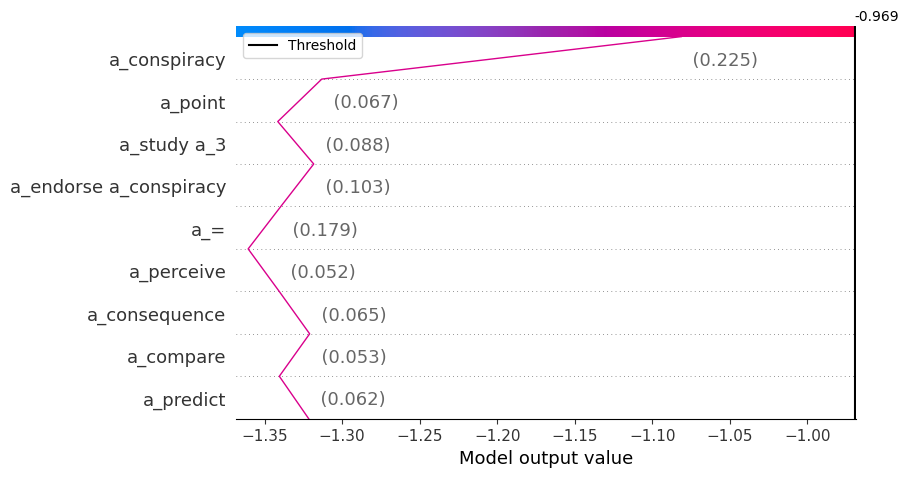

Truth: 1
Prediction: [1]
Shap value: 1.0009411737682328
Prediction score: [1.00094117]


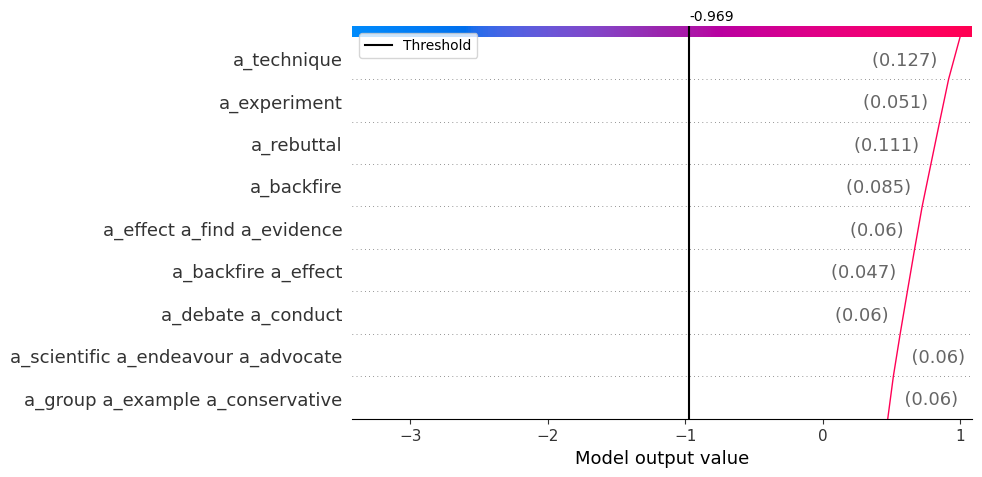

Truth: 0
Prediction: [0]
Shap value: -0.9838756824292454
Prediction score: [-0.98387568]


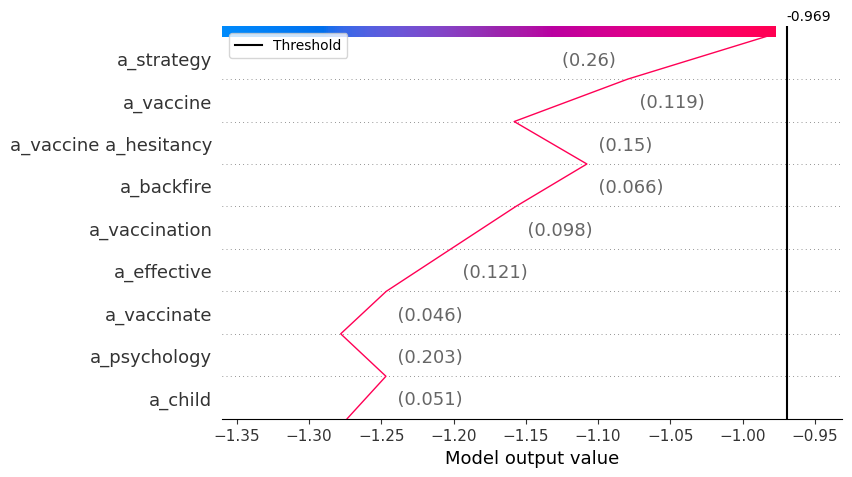

Truth: 0
Prediction: [0]
Shap value: -1.2824372881696056
Prediction score: [-1.28243729]


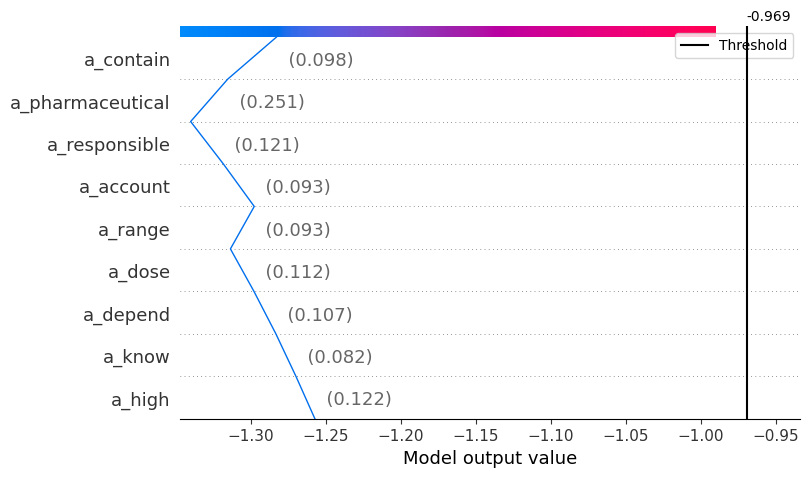

Truth: 0
Prediction: [0]
Shap value: -1.1144304088428192
Prediction score: [-1.11443041]


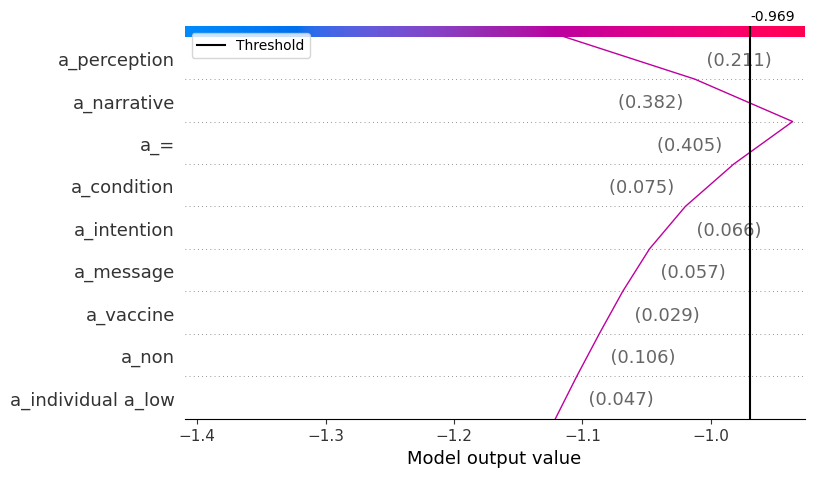

In [11]:
import numpy as np

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(
        f"Prediction: {raw_threshold_predict(model, np.expand_dims(X_test[i], axis=0), threshold)}"
    )
    print(
        f"Shap value: {np.sum(shap_plotter.shap_values[i]) + shap_plotter.expected_value}"
    )
    print(
        f"Prediction score: {predict_scores(model, np.expand_dims(X_test[i], axis=0))}"
    )
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()